In [3]:
import numpy as np
import csv
import ast
import random
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from collections import Counter


In [4]:
def generate_error():

    error_list = []
    with open('dataset/legitimate_channel_error.csv', newline='') as csvfile:
        
        for line in csvfile:
            error_list.append(ast.literal_eval(line.strip()))

    error_list_clean = [elem[0] if isinstance(elem, tuple) else elem for elem in error_list]

    return error_list_clean

In [5]:
def random_gen(n):
    if n <= 0:
        raise ValueError("n needs to be > 0")
    return random.randint(0, n - 1)

In [6]:
def binary_sum(x,y):

    result = []
    reminder = 0

    for i in reversed(range(len(x))):
        sum = x[i]+y[i]+reminder
        bit = sum%2
        reminder = sum // 2
        result.insert(0,bit)
    
    if reminder:
        result.insert(0,reminder)
    
    return result

In [7]:
def xor(x,y): #probabilmente si potrebbe usare numpy
    result = []
    for i in range(len(x)):
        result.append(x[i] ^ y[i])
    return result

In [8]:
def uniform_wiretap_channel(input, legit_error = generate_error, eve_error = generate_error):

    legitimate_error_list = legit_error()
    eavesdropper_error_list = eve_error()
    legitimate_error = legitimate_error_list[random_gen(8)]
    eavesdropper_error = eavesdropper_error_list[random_gen(8)]

    return (xor(input,legitimate_error),xor(input,eavesdropper_error))




In [9]:
def run_wiretap_simulation(input, num_runs=10**4):
    results = {}

    for _ in range(num_runs):
        y, z = uniform_wiretap_channel(input)

        # Convertiamo le liste x e y in tuple per una gestione più facile nel dizionario
        y_tuple = tuple(y)
        z_tuple = tuple(z)

        if (y_tuple, z_tuple) not in results:
            results[(y_tuple, z_tuple)] = 0
        results[(y_tuple, z_tuple)] += 1

    # Calcoliamo le probabilità
    probabilities = {key: count / num_runs for key, count in results.items()}
    
    return probabilities

# Funzione per dividere le probabilità per x e y
def divide_probabilities(probabilities):
    y_probabilities = {}
    z_probabilities = {}

    # Dividiamo le probabilità
    for (y, z), prob in probabilities.items():
        if y not in y_probabilities:
            y_probabilities[y] = 0
        if z not in z_probabilities:
            z_probabilities[z] = 0
        
        y_probabilities[y] += prob
        z_probabilities[z] += prob

    # Ordinamento delle probabilità
    y_probabilities = dict(sorted(y_probabilities.items()))
    z_probabilities = dict(sorted(z_probabilities.items()))

    return y_probabilities, z_probabilities

In [10]:
probabilities = run_wiretap_simulation([1,0,0,1,0,0,0],num_runs=10**4)
y_probabilities, z_probabilities = divide_probabilities(probabilities)

In [11]:
def plot_pmd_given_symbol_bits(z_probabilities, x=[1, 0, 0, 1, 0, 0, 0]):
    #print("Tipo di z_probabilities:", type(z_probabilities))
    #print("Esempio contenuto:", list(z_probabilities.items())[:5])

    z_values = []
    probabilities = []

    for z_tuple, prob in z_probabilities.items():
        if isinstance(z_tuple, tuple) and isinstance(prob, (int, float)):
            # Converti la tupla binaria in intero
            z_int = int(''.join(map(str, z_tuple)), 2)
            z_values.append(z_int)
            probabilities.append(prob)
        else:
            print("⚠️ Salto coppia non valida:", z_tuple, prob)

    z_values = np.array(z_values)
    probabilities = np.array(probabilities)

    # Ordina i dati per z intero
    sorted_indices = np.argsort(z_values)
    z_values = z_values[sorted_indices]
    probabilities = probabilities[sorted_indices]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(z_values, probabilities, color='skyblue')
    plt.xlabel("z (valore intero della sequenza binaria)")
    plt.ylabel("PMD")
    plt.title(f'PMD di $Z$ dato {x}')
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Somma delle probabilità in alto a sinistra
    plt.text(0.01, max(probabilities), f"Somma P = {np.sum(probabilities):.4f}", 
             fontsize=12, verticalalignment='top', horizontalalignment='left')

    plt.tight_layout()
    plt.show()

x = [1, 0, 0, 1, 0, 0, 0]

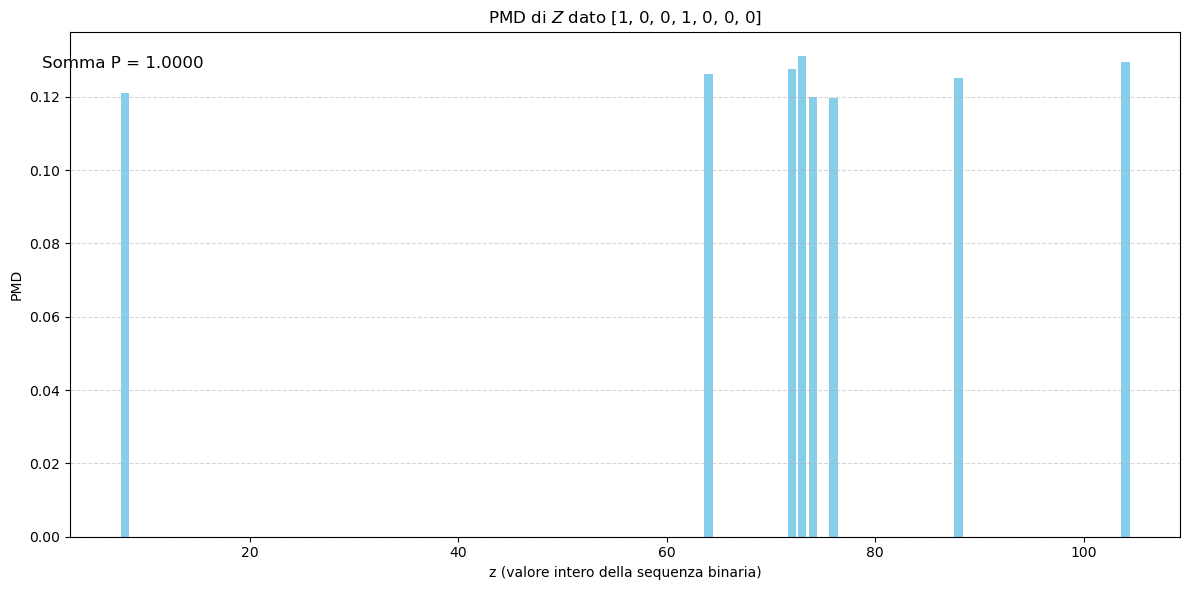

In [12]:
plot_pmd_given_symbol_bits(z_probabilities)

In [13]:
def analyze_error_distribution():
    error_list = generate_error()
    weights = [sum(e) for e in error_list]
    
    from collections import Counter
    distribution = Counter(weights)
    
    print("Distribuzione del peso (numero di bit a 1) nei vettori di errore:")
    for weight, count in sorted(distribution.items()):
        print(f"{weight} bit a 1: {count} occorrenze")

In [14]:
analyze_error_distribution()


Distribuzione del peso (numero di bit a 1) nei vettori di errore:
0 bit a 1: 1 occorrenze
1 bit a 1: 7 occorrenze


## Task 2

In [31]:
H = np.array([
    [1, 0, 0, 0, 1, 1, 1],
    [0, 1, 0, 1, 0, 1, 1],
    [0, 0, 1, 1, 1, 0, 1]
])
#print(f"x = {x}")
#print(y)
#print(z)

def error_correction(y,s):
    H = np.array([
        [1, 0, 0, 0, 1, 1, 1],
        [0, 1, 0, 1, 0, 1, 1],
        [0, 0, 1, 1, 1, 0, 1]
    ])

    e_hat = np.zeros_like(y)
    for i in range(7):
        e_i = H[:, i] % 2
        if np.array_equal(s, e_i):
            e_hat[i] = 1
    return xor(y, e_hat)

    
'''if c is computed by A is forward reconciliation
if c is computed by B is reverse reconciliation'''
def information_reconciliation(x, c):
    x = np.array(x)
    
    s = np.dot(H, x) % 2
    s = xor(c, s)

    x_hat = error_correction(x, s)

    return x_hat


def simulate_forward_information_reconciliation(channel, legit_error, eve_error, n_runtimes=10**2):

    success_Bob = 0
    success_Eve = 0

    for _ in range (n_runtimes):

        x = [random.randint(0,1) for i in range (7)]


        y, z = channel(x, legit_error, eve_error)

        c = np.dot(H, x) % 2 #computed by A and sended on public channel

        x_hat_Bob = information_reconciliation(y, c)
        x_hat_Eve = information_reconciliation(z, c)


        if np.array_equal(x, x_hat_Bob):

            success_Bob += 1
        if np.array_equal(x, x_hat_Eve):
            success_Eve += 1  


    return success_Bob/n_runtimes, success_Eve/n_runtimes  



In [32]:
success_Bob, success_Eve = simulate_forward_information_reconciliation(channel=uniform_wiretap_channel,
                                                                    legit_error=generate_error,
                                                                    eve_error=generate_error)

print(f"Success probability of information reconciliation for Bob: {success_Bob}")
print(f"Success probability of information reconciliation for Eve: {success_Eve}")


Success probability of information reconciliation for Bob: 1.0
Success probability of information reconciliation for Eve: 1.0


## Task 3

In [33]:
#A --> B

'''def reverse_reconciliation(x, c):
    x = np.array(x)
    
    s_A = np.dot(H, x) % 2
    s = xor(s_A, c)

    y_hat = error_correction(x, s)
    
    return y_hat'''


def simulate_reverse_information_reconciliation(n_runtimes=10**2):

    success_Alice = 0
    success_Eve = 0

    for _ in range (n_runtimes):

        x = [random.randint(0,1) for i in range (7)]


        y, z = uniform_wiretap_channel(x)

        c = np.dot(H, y) % 2  #computed by B and sended on public channel

        y_hat_Alice = information_reconciliation(x, c)
        y_hat_Eve = information_reconciliation(z, c)
        

        if np.array_equal(y, y_hat_Alice):
            success_Alice += 1
        if np.array_equal(y, y_hat_Eve):
            success_Eve += 1   
    return success_Alice/n_runtimes, success_Eve/n_runtimes  


In [34]:
success_Alice, success_Eve = simulate_reverse_information_reconciliation()

print(f"Success probability of information reconciliation for Bob: {success_Alice}")
print(f"Success probability of information reconciliation for Eve: {success_Eve}")


Success probability of information reconciliation for Bob: 1.0
Success probability of information reconciliation for Eve: 0.36


## Task 4

In [41]:
A = np.array([
    [1, 0, 0, 0, 0, 0, 1],
    [0, 1, 0, 0, 1, 1, 0],
    [0, 0, 1, 0, 1, 0, 0],
    [0, 0, 0, 1, 1, 0, 0]
])

def det_privacy_amplification(x, A=A):
    return np.dot(A, x) % 2


def prob_privacy_amplification(x, l):
    assert len(x) == 4
    M = np.random.randint(0, 2, size=(l, 4))
    result = np.dot(M,x) % 2
    return result


def privacy_amplification(x, l, A = A):
    x_prime = det_privacy_amplification(x, A)
    k = prob_privacy_amplification(x_prime, l)
    return k

In [56]:
def eval_det_privacy_amplification(iterations = 10**4, A = A):
    conj_prob = {}
    syndrome_prob = {}
    y_prime_prob = {}
    for _ in range(iterations):
        y = np.random.randint(0, 2, size=(7))
        c = np.dot(H, y) % 2
        y_prime = det_privacy_amplification(y, A = A)
        dict_key = (tuple(y_prime), tuple(c)) 
        if dict_key not in conj_prob:
            conj_prob[dict_key] = 0
        conj_prob[dict_key] += 1
        if tuple(c) not in syndrome_prob:
            syndrome_prob[tuple(c)] = 0
        syndrome_prob[tuple(c)] += 1
        if tuple(y_prime) not in y_prime_prob:
            y_prime_prob[tuple(y_prime)] = 0
        y_prime_prob[tuple(y_prime)] += 1

    conj_prob = {key: count / iterations for key, count in conj_prob.items()}
    conj_prob = dict(sorted(conj_prob.items()))

    syndrome_prob = {key: count / iterations for key, count in syndrome_prob.items()}
    syndrome_prob = dict(sorted(syndrome_prob.items()))

    y_prime_prob = {key: count / iterations for key, count in y_prime_prob.items()}
    y_prime_prob = dict(sorted(y_prime_prob.items()))

    # Verifica dell'indipendenza
    for (y_prime, c), prob in conj_prob.items():
        if y_prime in y_prime_prob and c in syndrome_prob:
            expected_prob = y_prime_prob[y_prime] * syndrome_prob[c]
            if not np.isclose(prob, expected_prob, atol=1e-3):
                print(f"Indipendenza violata per {np.array(y_prime)}, {np.array(c)}: P({np.array(y_prime)}, {np.array(c)}) = {prob}, "
                      f"atteso = {expected_prob}")
    else:
        print("Indipendenza verificata per tutte le coppie.")


    return conj_prob, syndrome_prob, y_prime_prob


In [57]:
conj_prob, syndrome_prob, y_prime_prob = eval_det_privacy_amplification(iterations=10**6)
print("Probabilità congiunta:")
for key, value in conj_prob.items():
    print(f"Probabilità di {np.array(key[0])} e {np.array(key[1])}: {value}")
print("Probabilità marginale del sindrome:")
for key, value in syndrome_prob.items():
    print(f"Probabilità di {np.array(key)}: {value}")
print("Probabilità marginale del vettore di errore:")
for key, value in y_prime_prob.items():
    print(f"Probabilità di {np.array(key)}: {value}")


Indipendenza verificata per tutte le coppie.
Probabilità congiunta:
Probabilità di [0 0 0 0] e [0 0 0]: 0.007842
Probabilità di [0 0 0 0] e [0 0 1]: 0.007927
Probabilità di [0 0 0 0] e [0 1 0]: 0.007938
Probabilità di [0 0 0 0] e [0 1 1]: 0.007857
Probabilità di [0 0 0 0] e [1 0 0]: 0.007685
Probabilità di [0 0 0 0] e [1 0 1]: 0.007773
Probabilità di [0 0 0 0] e [1 1 0]: 0.007857
Probabilità di [0 0 0 0] e [1 1 1]: 0.00781
Probabilità di [0 0 0 1] e [0 0 0]: 0.007811
Probabilità di [0 0 0 1] e [0 0 1]: 0.007769
Probabilità di [0 0 0 1] e [0 1 0]: 0.007857
Probabilità di [0 0 0 1] e [0 1 1]: 0.007748
Probabilità di [0 0 0 1] e [1 0 0]: 0.007869
Probabilità di [0 0 0 1] e [1 0 1]: 0.00799
Probabilità di [0 0 0 1] e [1 1 0]: 0.00782
Probabilità di [0 0 0 1] e [1 1 1]: 0.007871
Probabilità di [0 0 1 0] e [0 0 0]: 0.00763
Probabilità di [0 0 1 0] e [0 0 1]: 0.007652
Probabilità di [0 0 1 0] e [0 1 0]: 0.007699
Probabilità di [0 0 1 0] e [0 1 1]: 0.007815
Probabilità di [0 0 1 0] e [1 0 0]: 

From the result we have that $Ay = y^′ \sim \mathcal{U}(\{0,1\}^4)$ and  $$P(y'= a, c = b) = P(y'= a) * P(c = b)$$ which prove independence

## Task 5

In [ ]:

# --- Esperimento principale ---
def run_statistical_test(num_samples=1000, max_l=4):
    for l in range(1, max_l + 1):
        keys = []
        syndromes = []

        for _ in range(num_samples):
            y = np.random.randint(0, 2, size=7)
            k = privacy_amplification(y, A, l)
            c = np.dot(H, y) % 2
            keys.append(k)
            syndromes.append(c)

        keys = np.array(keys)
        syndromes = np.array(syndromes)

        print(f"\n=== Test for ℓ = {l} ===")
        evaluate_uniformity_and_independence(keys, syndromes)


In [48]:
run_statistical_test(num_samples=1000, max_l=4)


=== Test for ℓ = 1 ===

Evaluation over 1000 examples, length of key 1, length of syndrome 3
  Bit 0 of the key: freq(1) = 0.498000 (ideal: 0.5)
  Correlazion with syndrome:
    corr(k[0], c[0]) = 0.002
    corr(k[0], c[1]) = 0.012
    corr(k[0], c[2]) = 0.004

=== Test for ℓ = 2 ===

Evaluation over 1000 examples, length of key 2, length of syndrome 3
  Bit 0 of the key: freq(1) = 0.465000 (ideal: 0.5)
  Bit 1 of the key: freq(1) = 0.472000 (ideal: 0.5)
  Correlazion with syndrome:
    corr(k[0], c[0]) = 0.005
    corr(k[0], c[1]) = 0.007
    corr(k[0], c[2]) = 0.002
    corr(k[1], c[0]) = 0.043
    corr(k[1], c[1]) = -0.039
    corr(k[1], c[2]) = -0.029

=== Test for ℓ = 3 ===

Evaluation over 1000 examples, length of key 3, length of syndrome 3
  Bit 0 of the key: freq(1) = 0.472000 (ideal: 0.5)
  Bit 1 of the key: freq(1) = 0.512000 (ideal: 0.5)
  Bit 2 of the key: freq(1) = 0.466000 (ideal: 0.5)
  Correlazion with syndrome:
    corr(k[0], c[0]) = 0.005
    corr(k[0], c[1]) = 0.01

## Task 6

In [18]:
def binary_symmetric_channel(input,error):
    output=[]
    for bit in input:
        if random.random() <= error:
                output.append(bit ^ 1)
        else:
                output.append(bit)

    return output


def wiretap_bsc(x, legit_error = 0.1, eaves_error = 0.3):
    y = binary_symmetric_channel(x, legit_error)
    z = binary_symmetric_channel(x, eaves_error)
    return y, z

In [19]:
def evaluate_BSC(error=0.1,iterations=10**5):
    x = [0,0,0,0,0,0,0]
    #error = 0.1
    n_bit_error = 0

    for i in range(iterations):
        x_bsc = binary_symmetric_channel(x,error)
        for i in range(7):
            if x_bsc[i]==1:
                n_bit_error+=1

    return n_bit_error, n_bit_error/(iterations*len(x))

In [20]:
errors = [0.1, 0.3, 0.5, 0.7]
for error in errors:
    iterations = 10**5
    n_bit_error, error_rate = evaluate_BSC(error, iterations)
    print(f"Average number of errors in BSC with error rate {error}: {error_rate:.4f} ({n_bit_error} errors in {iterations} iterations)")

Average number of errors in BSC with error rate 0.1: 0.1003 (70195 errors in 100000 iterations)
Average number of errors in BSC with error rate 0.3: 0.3000 (210002 errors in 100000 iterations)
Average number of errors in BSC with error rate 0.5: 0.5010 (350713 errors in 100000 iterations)
Average number of errors in BSC with error rate 0.7: 0.7002 (490136 errors in 100000 iterations)


In [21]:
success_Bob, success_Eve = simulate_forward_information_reconciliation(channel=wiretap_bsc,
                                            legit_error=0.1,
                                            eve_error=0.3)

print(f"Success probability of information reconciliation for Bob: {success_Bob}")
print(f"Success probability of information reconciliation for Eve: {success_Eve}")


Success probability of information reconciliation for Bob: 0.88
Success probability of information reconciliation for Eve: 0.26
